In [1]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import unicodedata
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import f1_score
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from collections import Counter
import ast
import random
import json
from math import isnan
from tqdm import tqdm

import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1" ###指定此处为-1即可

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 10
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

c:\Users\csujk\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda', index=0)

## New Section

In [2]:
from transformers import BertTokenizer,BertModel
# PRE_TRAINED_MODEL_NAME = "../hfl/chinese-roberta-wwm-ext"
# PRE_TRAINED_MODEL_NAME = "hfl/chinese-roberta-wwm-ext-large"
# PRE_TRAINED_MODEL_NAME = "hfl/chinese-bert-wwm-ext"
# PRE_TRAINED_MODEL_NAME = "bert-base-uncased"
# PRE_TRAINED_MODEL_NAME = "ProsusAI/finbert"
PRE_TRAINED_MODEL_NAME = "../hfl/bert-base-chinese"
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,do_lower_case=True)
PRE_TRAINED_MODEL_NAME = '../model/ROBERT_4_model.bin'

## Generating the masks of verb, A0, A1

In [3]:
df_train = pd.read_csv('d:/data/pre/train.csv',sep='\t')
df_val = pd.read_csv('d:/data/pre/val.csv',sep='\t')
df_test = pd.read_csv('d:/data/pre/test.csv',sep='\t')
df_ood = pd.read_csv('d:/data/pre/ood.csv',sep='\t')

df_train = df_train.drop(df_train.loc[df_train.verbA0A1.isna()].index)
df_test = df_test.drop(df_test.loc[df_test.verbA0A1.isna()].index)
df_val = df_val.drop(df_val.loc[df_val.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)

df_train = df_train.drop(df_train.loc[df_train.verbA0A1=='[]'].index)
df_test = df_test.drop(df_test.loc[df_test.verbA0A1=='[]'].index)
df_val = df_val.drop(df_val.loc[df_val.verbA0A1=='[]'].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)

def string_to_tuples_list(text):
  if text is np.nan or text =='[]':
    return []
  text = ''.join(text.split('], ['))
  tmp = eval(text.strip('[').strip(']'))
  if not isinstance(tmp[0],tuple):
    return [tmp]
  return list(tmp)

for col in ['verb','A0','A1']:
  df_train[col] = df_train[col].apply(string_to_tuples_list)
  df_val[col] = df_val[col].apply(string_to_tuples_list)
  df_test[col] = df_test[col].apply(string_to_tuples_list)
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
# for col in ['verbA0A1']:
  df_train[col] = df_train[col].apply(ast.literal_eval)
  df_val[col] = df_val[col].apply(ast.literal_eval)
  df_test[col] = df_test[col].apply(ast.literal_eval)
  df_ood[col] = df_ood[col].apply(ast.literal_eval)

def mask(df):
  df = df.reset_index(drop = True)
  df['verb_mask'] = 0
  df['A0_mask'] = 0
  df['A1_mask'] = 0
  df['verb_mask'] = df['verb_mask'].astype('object')
  df['A0_mask'] = df['A0_mask'].astype('object')
  df['A1_mask'] = df['A1_mask'].astype('object')
  for index,row in df.iterrows():

    df.at[index,'stock_factors'] = [*map(float,df.loc[index,'stock_factors'])]
    AV_num = 0
    for k,col in enumerate(['verb','A0','A1']):
      masks = []
      for j in range(len(row['verbA0A1'])):
        mask = np.zeros(299)
        idx = []
        for v in row['verbA0A1'][j][k]:
          
          idx = idx + [int(i) for i in range(v[0],v[0]+v[1])]
        # idx = np.unique(idx).tolist()
        counter = Counter(idx)

        mask = [0 if counter[i]== 0 else 1/len(counter) for i in range(0,len(mask))]
        mask.insert(0,0)
        masks.append(mask)
      AV_num = len(masks)
      for i in range(10 - len(masks)):
        masks.append(np.zeros(300))
      while len(masks)>10:
        masks.pop()
      name = col+'_mask'
      df.at[index,name] = np.array(masks)
    if AV_num>10:
      AV_num=10
    df.loc[index,'AV_num'] = int(AV_num)
  df.AV_num = df.AV_num.astype('int')
  df.stock_factors = df.stock_factors.apply(np.array)
  return df


df_train = mask(df_train)
df_test = mask(df_test)
df_val = mask(df_val)
df_ood = mask(df_ood)

In [4]:
# max(df_train.verb_mask.apply(len))

In [5]:
# df_train.to_csv('./data/df_train_srl.csv',sep='\t',index=None)
# df_test.to_csv('./data/df_test_srl.csv',sep='\t',index=None)
# df_val.to_csv('./data/df_val_srl.csv',sep='\t',index=None)
# df_ood.to_csv('./data/df_ood_srl.csv',sep='\t',index=None)

Text(0.5, 0, 'review score')

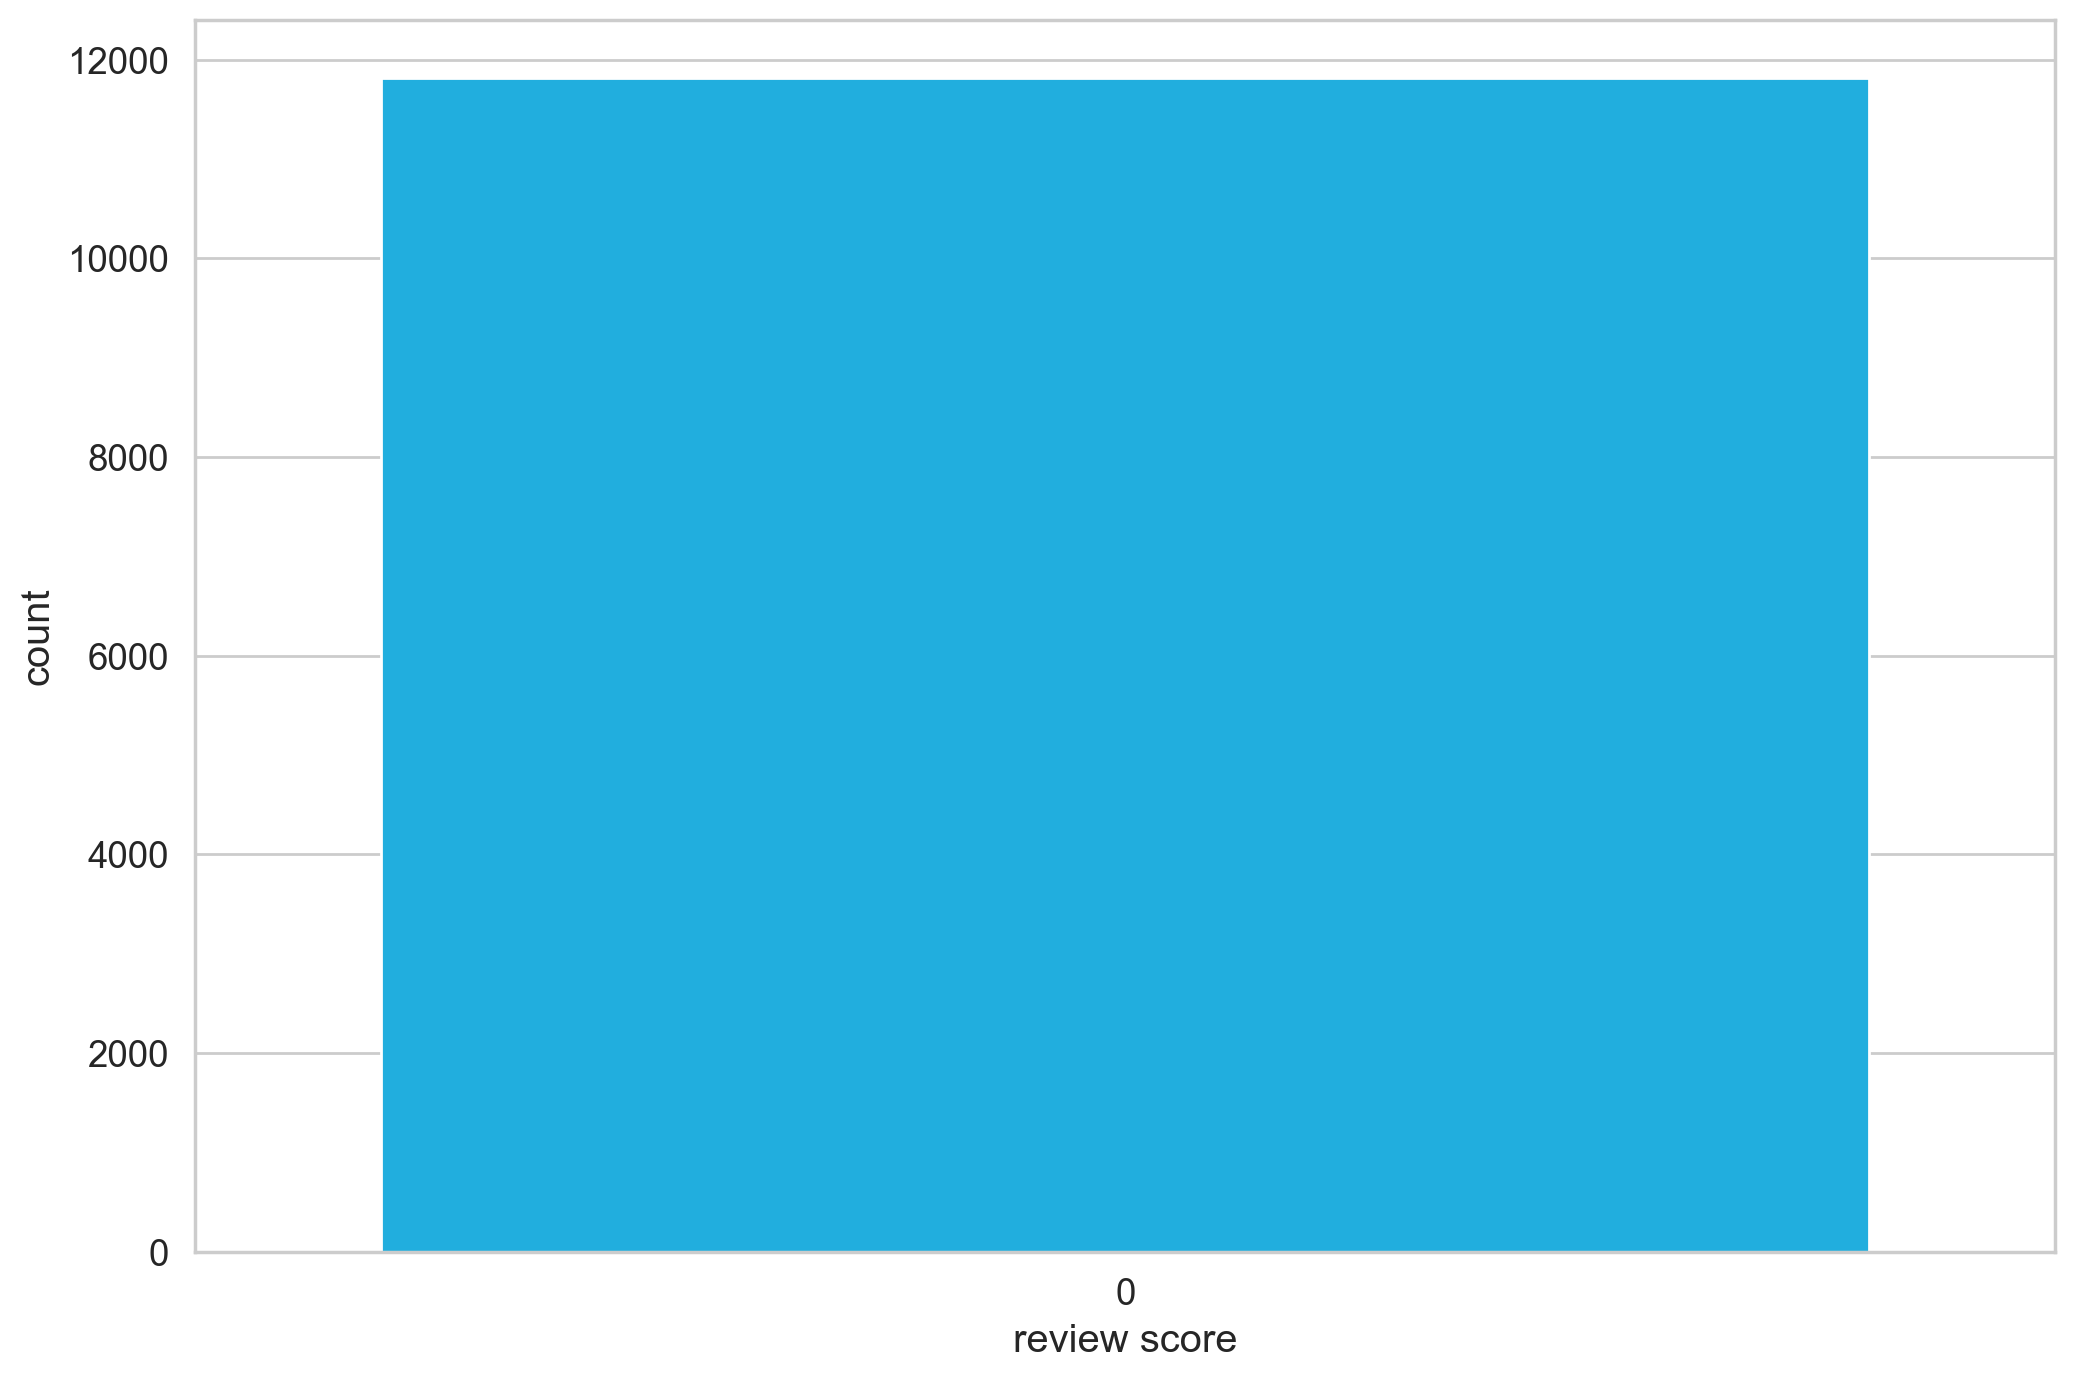

In [6]:
sns.countplot(df_train.label)
plt.xlabel('review score')

In [7]:
total = pd.concat([df_train,df_test,df_val])

In [8]:
total.sort_values(by='DATE')

,CODE,DATE,label,text_a,verb,A0,A1,verbA0A1,verb_mask,A0_mask,...,day2,open3,close3,day3,open4,close4,day4,open5,close5,day5
1456,2699,2018-07-23 18:31:00,2,美盛文化(sz002699)公告，拟发起设立康元人寿保险股份有限公司，公司出资额为4亿元，占...,"[(14, 1), (17, 2), (37, 1), (42, 1)]","[(32, 2), (34, 3), (32, 2), (34, 3)]","[(15, 2), (17, 2), (19, 2), (21, 4), (25, 2), ...","[[[(37, 1)], [(32, 2), (34, 3)], [(38, 2), (40...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,2018-07-26,18.0000,17.9500,2018-07-27,18.0500,17.5900,2018-07-30,17.5800,17.6000,2018-07-31
5345,601668,2018-07-23 18:36:00,2,中国建筑晚间发布公告，近期本公司获得广东珠海横琴科学城、澳大利亚复华耀世 SPIRIT 项目...,"[(6, 2), (16, 2), (69, 1)]","[(0, 2), (2, 2), (56, 2), (58, 2), (13, 1), (1...","[(70, 1), (71, 2), (73, 2), (75, 2), (77, 1), ...","[[[(6, 2)], [(0, 2), (2, 2)], [(8, 2)]], [[(16...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5,...","[[0.0, 0.25, 0.25, 0.25, 0.25, 0.0, 0.0, 0.0, ...",...,2018-07-26,5.1257,5.1436,2018-07-27,5.1526,5.2422,2018-07-30,5.1974,5.1974,2018-07-31
2098,2636,2018-07-24 01:25:00,2,金安国纪(sz002636)公告，今年以来，覆铜板市场发生了较大的变化，电子电路产业深层次发...,"[(24, 2), (28, 1), (47, 2), (56, 2), (106, 2),...","[(30, 2), (54, 2), (27, 1), (28, 1), (29, 1), ...","[(49, 2), (51, 2), (102, 1), (103, 3), (19, 3)...","[[[(24, 2)], [(19, 3), (22, 2)], [(27, 1), (28...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",...,2018-07-26,9.5300,9.4700,2018-07-27,9.4200,9.2900,2018-07-30,9.2100,9.4400,2018-07-31
4613,2243,2018-07-24 02:57:00,0,通产丽星(sz002243)异动公告称，公司富勒烯碳纳米工程实验室取得的研究成果处于实验室阶...,"[(15, 1), (30, 2), (37, 2), (45, 2), (60, 2), ...","[(0, 4), (4, 1), (5, 5), (10, 1), (11, 4), (17...","[(47, 3), (50, 1), (51, 3), (54, 1), (55, 2), ...","[[[(15, 1)], [(0, 4), (4, 1), (5, 5), (10, 1),...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.06666666666666667, 0.0666666666666666...",...,2018-07-26,10.1917,10.2704,2018-07-27,10.0343,9.2965,2018-07-30,9.0899,8.9030,2018-07-31
625,300024,2018-07-24 02:57:00,1,美的集团斥资约40亿元回购股票事宜在今天（7月23日）下午的股东大会上获得通过。在回答投资人...,"[(4, 2), (10, 2), (33, 2), (39, 2), (60, 2), (...","[(0, 1), (1, 1), (2, 2), (0, 1), (1, 1), (2, 2...","[(12, 2), (41, 3), (44, 1), (45, 2), (6, 3), (...","[[[(4, 2)], [(0, 1), (1, 1), (2, 2)], [(6, 3),...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0,...","[[0.0, 0.25, 0.25, 0.25, 0.25, 0.0, 0.0, 0.0, ...",...,2018-07-26,17.4000,17.3700,2018-07-27,17.3600,17.0500,2018-07-30,17.1000,17.0900,2018-07-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1771,300246,2020-12-31 20:20:00,1,宝莱特披露2021年限制性股票激励计划(草案)，该激励计划拟授予的限制性股票数量为280万股...,"[(3, 2), (26, 1), (27, 2), (37, 1), (42, 1), (...","[(0, 3), (21, 1), (22, 2), (24, 2), (26, 1), (...","[(27, 2), (33, 2), (67, 2), (69, 2), (71, 2), ...","[[[(3, 2)], [(0, 3)], [(5, 2), (7, 3), (10, 2)...","[[0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0, 0.0,...","[[0.0, 0.3333333333333333, 0.3333333333333333,...",...,2021-01-06,26.2456,25.0214,2021-01-07,24.7864,25.4425,2021-01-08,25.5503,26.1085,2021-01-11
5358,300008,2020-12-31 21:05:00,2,天海防务公告，公司收到法院民事裁定书，裁定公司重整计划执行完毕。天海防务表示，重整计划的执行...,"[(9, 2), (27, 2), (29, 2), (36, 2), (48, 2), (...","[(7, 2), (32, 4), (39, 2), (41, 2), (43, 1), (...","[(21, 2), (23, 2), (25, 2), (76, 2), (78, 2), ...","[[[(9, 2)], [(7, 2)], [(11, 2), (13, 2), (15, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5,...",...,2021-01-06,7.0800,7.2500,2021-01-07,7.2600,6.7600,2021-01-08,6.9600,6.6400,2021-01-11
3551,300087,2020-12-31 21:17:00,2,荃银高科公告，股东贾桂兰、王玉林将所持公司全部股份（占公司总股本8.23%）的表决权委托给公...,"[(26, 1), (41, 2), (72, 2), (84, 1), (96, 2), ...","[(7, 2), (9, 3), (12, 1), (13, 3), (127, 2), (...","[(27, 2), (29, 1), (30, 2), (98, 2), (100, 2),...","[[[(41, 2)], [(7, 2), (9, 3), (12, 1), (13, 3)...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11...",...,2021-01-06,35.9857,3

## Creat Dataloader

In [9]:
max_len = 300
class_names = ['negative','neutral', 'positive']
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets,verb,A0,A1,AV_num,tokenizer,stock_factors, max_len):
    self.reviews = reviews
    self.targets = targets
    self.stock_factors = stock_factors
    self.verb = verb
    self.A0 = A0
    self.A1 = A1
    self.AV_num = AV_num
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    stock_factors = self.stock_factors[item]
    v = self.verb[item]
    a0 = self.A0[item]
    a1 = self.A1[item]
    av_num = self.AV_num[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long),
      'stock_factors':torch.tensor(stock_factors),
      'verb': torch.tensor(v),
      'A0': torch.tensor(a0),
      'A1': torch.tensor(a1),
      'AV_num': torch.tensor(av_num)
    }

In [10]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text_a.to_numpy(),
    targets=df.label.to_numpy(),
    stock_factors = df.stock_factors,
    verb = df.verb_mask,
    A0 = df.A0_mask,
    A1 = df.A1_mask,
    AV_num = df.AV_num,
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    # num_workers=4,
    shuffle=True
  )

In [11]:

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_ood = df_ood.reset_index(drop=True)

In [12]:
BATCH_SIZE = 2

train_data_loader = create_data_loader(df_train, tokenizer, max_len, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, max_len, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, max_len, BATCH_SIZE)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

## Model

In [13]:
NUMBER_FACTOR = 24
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,output_attentions=True)
    self.encoder_layer =  nn.TransformerEncoderLayer(d_model=2304+NUMBER_FACTOR, nhead=1)
    self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
    self.drop = nn.Dropout(p=0.1)
    # self.L1 = nn.Linear(self.bert.config.hidden_size*30, self.bert.config.hidden_size*3)
    self.out1 = nn.Linear((self.bert.config.hidden_size*3+NUMBER_FACTOR)*10, (self.bert.config.hidden_size*3+NUMBER_FACTOR)*3)
    self.out = nn.Linear((self.bert.config.hidden_size*3+NUMBER_FACTOR)*3, n_classes)
    self.linear_for_stock_factors = nn.Linear(NUMBER_FACTOR,NUMBER_FACTOR)
    self.flatten2 = nn.Flatten(2,-1)
    self.flatten = nn.Flatten(1,-1)
    self.relu = nn.ReLU()
    self.sig = nn.Sigmoid()
    self.Querry = nn.Linear(self.bert.config.hidden_size,self.bert.config.hidden_size,bias = False)
    self.Key = nn.Linear(self.bert.config.hidden_size,self.bert.config.hidden_size,bias = False)
    # self.Self_supervised = nn.Linear(self.bert.config.hidden_size,self.bert.config.hidden_size)

  
  def forward(self, input_ids, attention_mask,verb,A0,A1,stock_factors,AV_num):
    #get bert embedding 
    hidden_state = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )[0]
    batch = hidden_state.shape[0]
    verb_tmp = verb.clone()

    #stock_factor(8*24)
    stock_factors_batch = stock_factors[:,:NUMBER_FACTOR]
    stock_factors_batch = self.linear_for_stock_factors(stock_factors_batch.float())
    stock_factors_batch = self.relu(stock_factors_batch)
    stock_factors_batch = torch.unsqueeze(stock_factors_batch,1) #8*1*2304
    stock_factors_batch= torch.cat(10*[stock_factors_batch],1)

    #mask verb
    AV_idx = []
    for idx,num in enumerate(AV_num):
      self_label = torch.randint(0,num,(1,))[0]
      AV_idx.append(self_label)
      verb_tmp[idx,self_label,:]=0
      stock_factors_batch[idx] = torch.cat(num*[torch.unsqueeze(stock_factors_batch[idx][0],0)]+(10-num)*[torch.zeros((1,NUMBER_FACTOR)).to(device)])

    #verb label
    AV_idx = torch.tensor(AV_idx).to(device)

    V_mask = torch.unsqueeze(verb,3)
    V_mask = torch.cat(768 * [V_mask],3)
    V_mask = torch.mean(V_mask*torch.unsqueeze(hidden_state,1),2,True)
    K = self.Key(torch.squeeze(V_mask.float()))
    

    # get verb embedding after masking(8*10*1*768)
    V_mask_mask = torch.unsqueeze(verb_tmp,3)
    V_mask_mask = torch.cat(768 * [V_mask_mask],3)
    transformer_input = torch.mean(V_mask_mask*torch.unsqueeze(hidden_state,1),2,True)

    #get A0 embedding(8*10*2*768)
    A0_mask = torch.unsqueeze(A0,3)
    A0_mask = torch.cat(768 * [A0_mask],3)
    A0_mask = torch.mean(A0_mask*torch.unsqueeze(hidden_state,1),2,True)
    transformer_input = torch.cat([transformer_input,A0_mask],2)

    #get A1 embedding(8*10*3*768)
    A1_mask = torch.unsqueeze(A1,3)
    A1_mask = torch.cat(768 * [A1_mask],3)
    A1_mask = torch.mean(A1_mask*torch.unsqueeze(hidden_state,1),2,True)
    transformer_input = torch.cat([transformer_input,A1_mask],2)

    #get transformer input(8*10*2304)
    transformer_input = self.flatten2(transformer_input.float())
    transformer_input = torch.cat([transformer_input,stock_factors_batch],2)


    #turn to (11*8*2304)
    transformer_input = torch.stack([transformer_input[:,i,:] for i in range(0,len(verb[0]))])
    
    #get transformer output(11*8*2304)
    transformer_output = self.transformer_encoder(transformer_input)

    #turn to (8*11*2304)
    transformer_output = torch.stack([torch.squeeze(transformer_output[:,i,:]) for i in range(0,batch)])
    transformer_output = torch.squeeze(transformer_output)

    #turn to (8*11*2304)
    self_pred = torch.zeros((batch,10))
    if transformer_output.dim()==2:
      transformer_output = torch.unsqueeze(transformer_output,0)

    #Q For CL
    for idx,i in enumerate(AV_idx):
      Q = torch.unsqueeze(self.Querry(transformer_output[idx,i,0:768]),0)
      self_pred[idx]=(Q @ K[idx].T)

    #get transformer input for classification(8*10*3*768)
    transformer_input = torch.cat([V_mask,A0_mask,A1_mask],2)

    #get transformer input(8*11*2304)
    transformer_input = self.flatten2(transformer_input.float())
    transformer_input = torch.cat([transformer_input,stock_factors_batch],2)


    #get transformer output(11*8*2304)
    transformer_input = torch.stack([transformer_input[:,i,:] for i in range(0,len(transformer_input[0]))])
    transformer_output = self.transformer_encoder(transformer_input)

    #turn to (8*11*2304)
    transformer_output = torch.stack([torch.squeeze(transformer_output[:,i,:]) for i in range(0,batch)])
    transformer_output = torch.squeeze(transformer_output)

    # handle exception
    if transformer_output.dim()==2:
      transformer_output = torch.unsqueeze(transformer_output,0)

    output = self.flatten(transformer_output.float())
    output = self.sig(output)
#     output = self.drop(output)
    output = self.out1(output)
    output = self.sig(output)
    output = self.drop(output)
    output = self.out(output)
    

    return output,self_pred,AV_idx

In [14]:
model = SentimentClassifier(3)
model = model.to(device)

Some weights of the model checkpoint at ../model/ROBERT_4_model.bin were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ../model/ROBERT_4_model.bin and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.de

In [15]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=2,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)
# loss_fn = nn.KLDivLoss(reduce=False,size_average=False).to(device)

c:\Users\csujk\anaconda3\envs\torch\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
import  datetime

In [17]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  correct_predictions_verbs = 0

  # print(len(data_loader))
  # i = 0

  for d in tqdm(data_loader):
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    stock_factors = d['stock_factors'].to(device)
    verb = d["verb"].to(device)
    A0 = d["A0"].to(device)
    A1 = d["A1"].to(device)
    AV_num = d["AV_num"].to(device)
    # print(i,datetime.datetime.now())
    # i += 1
    
    outputs,self_outputs,self_labels = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      verb = verb,
      A0 = A0,
      A1 = A1,
      stock_factors = stock_factors,
      AV_num = AV_num
    )
    self_outputs = self_outputs.to(device)
    self_labels = self_labels.to(device)



    if outputs.dim()==1:
      outputs = torch.unsqueeze(outputs,0)
    _, preds = torch.max(outputs, dim=1)
    _, self_preds = torch.max(self_outputs, dim=1)

    # print(targets.shape,outputs.shape)
    loss = 0.8*loss_fn(outputs, targets)+0.2*loss_fn(self_outputs,self_labels)

    correct_predictions += torch.sum(preds == targets)
    correct_predictions_verbs += torch.sum(self_preds == self_labels)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses),correct_predictions_verbs.double()/n_examples

In [18]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      stock_factors = d['stock_factors'].to(device)
      verb = d["verb"].to(device)
      A0 = d["A0"].to(device)
      A1 = d["A1"].to(device)
      AV_num = d["AV_num"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        verb = verb,
        A0 = A0,
        A1 = A1,
        stock_factors = stock_factors,
        AV_num = AV_num
      )[0]
      
      if outputs.dim()==1:
        outputs = torch.unsqueeze(outputs,0)
      _, preds = torch.max(outputs, dim=1)
      
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [19]:
history = defaultdict(list)
best_accuracy = 0
best_train_accuracy = 0
# EPOCHS = 5

In [20]:
%%time

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss, cl_acc = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc} cl_accuracy{cl_acc}')


  if train_acc > best_train_accuracy:
    torch.save(model.state_dict(), 'best_train_model_state.bin')
    best_train_accuracy = train_acc
    print("save to best train model")

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)


  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'Factor24_Pretrained_RoBert_SRL(FC)_V.bin')
    best_accuracy = val_acc
    print("save to best model")

Epoch 1/10
----------


100%|█████████▉| 5907/5908 [16:04<00:00,  6.04it/s]C:\Users\csujk\AppData\Local\Temp\ipykernel_18132\3730140471.py:96: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3281.)
  self_pred[idx]=(Q @ K[idx].T)
100%|██████████| 5908/5908 [16:04<00:00,  6.13it/s]


Train loss 0.9834016395660877 accuracy 0.5115531104528142 cl_accuracy0.5823106220905628
save to best train model
Val   loss 0.9661212350280908 accuracy 0.5592417061611374

save to best model
Epoch 2/10
----------


100%|██████████| 5908/5908 [16:54<00:00,  5.82it/s]


Train loss 0.9503011898842741 accuracy 0.5954295387219636 cl_accuracy0.573338975878121
save to best train model
Val   loss 1.0226131439302242 accuracy 0.6086662153012864

save to best model
Epoch 3/10
----------


100%|██████████| 5908/5908 [21:13<00:00,  4.64it/s]


Train loss 0.9945684028306242 accuracy 0.6520524756665256 cl_accuracy0.573338975878121
save to best train model
Val   loss 1.1613652013892533 accuracy 0.6384563303994584



In [ ]:
plt.plot([i.cpu() for i in history['train_acc']], label='trainw accuracy')
plt.plot([i.cpu() for i in history['val_acc']], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('Factor24_Pretrained_RoBert_SRL(FC)_V.bin'))
model = model.to(device)

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

In [ ]:
text=df_test.loc[df_test.text_a.apply(len)<100].sample(n=1).text_a.values[0]

text_final = ''
for i in tokenizer.tokenize(text):
    tem = ' '+i
    text_final+=tem

text_final = text_final[1:]



#Credits to Lin Zhouhan(@hantek) for the complete visualization code
import random, os, numpy, scipy
from codecs import open
def createHTML(texts, weights, fileName):
    """
    Creates a html file with text heat.
weights: attention weights for visualizing
texts: text on which attention weights are to be visualized
    """
    fileName = "./visualization/"+fileName
    fOut = open(fileName, "w", encoding="utf-8")
    part1 = """
    <html lang="zh-Hans">
    <head>
    <meta http-equiv="content-type" content="text/html; charset=utf-8">
    <style>
    body {
    font-family: Sans-Serif;
    }
    </style>
    </head>
    <body>
    <h3>
    Heatmaps
    </h3>
    </body>
    <script>
    """
    part2 = """
    var color = "255,0,0";
    var ngram_length = 3;
    var half_ngram = 1;
    for (var k=0; k < any_text.length; k++) {
    var tokens = any_text[k].split(" ");
    var intensity = new Array(tokens.length);
    var max_intensity = Number.MIN_SAFE_INTEGER;
    var min_intensity = Number.MAX_SAFE_INTEGER;
    for (var i = 0; i < intensity.length; i++) {
    intensity[i] = 0.0;
    for (var j = -half_ngram; j < ngram_length-half_ngram; j++) {
    if (i+j < intensity.length && i+j > -1) {
    intensity[i] += trigram_weights[k][i + j];
    }
    }
    if (i == 0 || i == intensity.length-1) {
    intensity[i] /= 2.0;
    } else {
    intensity[i] /= 3.0;
    }
    if (intensity[i] > max_intensity) {
    max_intensity = intensity[i];
    }
    if (intensity[i] < min_intensity) {
    min_intensity = intensity[i];
    }
    }
    var denominator = max_intensity - min_intensity;
    for (var i = 0; i < intensity.length; i++) {
    intensity[i] = (intensity[i] - min_intensity) / denominator;
    }
    if (k%2 == 0) {
    var heat_text = "<p><br><b>Example:</b><br>";
    } else {
    var heat_text = "<b>Example:</b><br>";
    }
    var space = " ";
    for (var i = 0; i < tokens.length; i++) {
    heat_text += "<span style='background-color:rgba(" + color + "," + intensity[i] + ")'>"  + tokens[i] + "</span>";
    if (space == "") {
    space = " ";
    }
    }
    //heat_text += "<p>";
    document.body.innerHTML += heat_text;
    }
    </script>
    </html>"""
    putQuote = lambda x: "\"%s\""%x
    textsString = "var any_text = [%s];\n"%(",".join(map(putQuote, texts)))
    weightsString = "var trigram_weights = [%s];\n"%(",".join(map(str,weights)))
#     print(part1)
#     print(textsString)
#     print(part2)
#     print(weightsString)
    fOut.write(part1)
    fOut.write(textsString)
    fOut.write(weightsString)
    fOut.write(part2)
    fOut.close()
  
    return
# ===================================================
# 2. add text and get weight
# ===================================================
text1 = text_final
tok = tokenizer.tokenize(text1)
# text2 = 'NEWS'
# p_pos = len(tok1)
# tok2 = tokenizer.tokenize(text2)
# tok = tok1+tok2

ids = torch.tensor(tokenizer.convert_tokens_to_ids(tok)).unsqueeze(0).to('cuda')

with torch.no_grad():
    output = model.bert(ids)
attentions = torch.cat(output[2]).to('cpu')

# =================================================
# 3. creat html attention heat map
# =================================================
createHTML([text1],[attentions[11,3,0,1:-2].numpy().tolist()],'Factor24_Pretrained_RoBert_SRL(FC)_V.html')


In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      verb = d["verb"].to(device)
      stock_factors = d['stock_factors'].to(device)
      A0 = d["A0"].to(device)
      A1 = d["A1"].to(device)
      AV_num = d['AV_num'].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        verb = verb,
        A0 = A0,
        A1 = A1,
        stock_factors = stock_factors,
        AV_num = AV_num
      )[0]
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values


In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

# df = pd.DataFrame([y_review_texts, y_pred.numpy(), y_pred_probs.numpy(), y_test.numpy()]).T
# df = df.rename(columns={0:'text',1:'prediction',2:'probability',3:'labels'})
# df.to_csv('/content/drive/MyDrive/data/df_prediction_roberta_srl_cl_f.csv',sep='\t')

print(classification_report(y_test, y_pred, target_names=class_names,digits=4))

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=list(class_names), columns=list(class_names))
show_confusion_matrix(df_cm)

### OOD Result

In [ ]:
y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=list(class_names), columns=list(class_names))
show_confusion_matrix(df_ood_cm)

In [ ]:
df_ood = pd.read_csv('d:\data\pre\ood.csv',sep='\t')
df_ood = df_ood.loc[(df_ood.DATE>='2021-01-01')&(df_ood.DATE<='2021-03-31')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=list(class_names), columns=list(class_names))
show_confusion_matrix(df_ood_cm)
plt.show()

df_ood = pd.read_csv('d:\data\pre\ood.csv',sep='\t')
df_ood = df_ood.loc[(df_ood.DATE>='2021-04-01')&(df_ood.DATE<='2021-06-31')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=list(class_names), columns=list(class_names))
show_confusion_matrix(df_ood_cm)
plt.show()

df_ood = pd.read_csv('d:\data\pre\ood.csv',sep='\t')
df_ood = df_ood.loc[(df_ood.DATE>='2021-07-01')&(df_ood.DATE<='2021-09-31')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=list(class_names), columns=list(class_names))
show_confusion_matrix(df_ood_cm)
plt.show()

df_ood = pd.read_csv('d:\data\pre\ood.csv',sep='\t')
df_ood = df_ood.loc[df_ood.DATE>='2021-10-01']
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:4000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=list(class_names), columns=list(class_names))
show_confusion_matrix(df_ood_cm)
plt.show()

In [ ]:
df_ood = pd.read_csv('d:\data\df_all_year_srl.csv',sep='\t')
# df_ood = df_ood.loc[(df_ood.DATE>='2021-05-05')&(df_ood.DATE<='2021-09-01')]
df_ood = df_ood.sort_values(by='DATE')
df_ood = df_ood.reset_index(drop=True)
# df_ood = df_ood.loc[:2000]
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1.isna()].index)
df_ood = df_ood.drop(df_ood.loc[df_ood.verbA0A1=='[]'].index)
for col in ['verb','A0','A1']:
  df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
  df_ood[col] = df_ood[col].apply(ast.literal_eval)
df_ood = mask(df_ood)
df_ood = df_ood.reset_index(drop=True)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=list(class_names), columns=list(class_names))
show_confusion_matrix(df_ood_cm)

In [ ]:
df = pd.DataFrame([y_ood_review_texts, y_ood_pred.numpy(), y_ood_pred_probs.numpy(), y_ood.numpy()]).T
df = df.rename(columns={0:'text',1:'prediction',2:'probability',3:'labels'})
df.to_csv('Factor24_Pretrained_RoBert_SRL(FC)_V_ood.csv',sep='\t')

In [ ]:
import random, os, numpy, scipy
from codecs import open
def createHTML(texts, weights, fileName):
    """
    Creates a html file with text heat.
weights: attention weights for visualizing
texts: text on which attention weights are to be visualized
    """
    fileName = "visualization/"+fileName
    fOut = open(fileName, "w", encoding="utf-8")
    part1 = """
    <html lang="en">
    <head>
    <meta http-equiv="content-type" content="text/html; charset=utf-8">
    <style>
    body {
    font-family: Sans-Serif;
    }
    </style>
    </head>
    <body>
    <h3>
    Heatmaps
    </h3>
    </body>
    <script>
    """
    part2 = """
    var color = "255,0,0";
    var ngram_length = 3;
    var half_ngram = 1;
    for (var k=0; k < any_text.length; k++) {
    var tokens = any_text[k].split(" ");
    var intensity = new Array(tokens.length);
    var max_intensity = Number.MIN_SAFE_INTEGER;
    var min_intensity = Number.MAX_SAFE_INTEGER;
    for (var i = 0; i < intensity.length; i++) {
    intensity[i] = 0.0;
    for (var j = -half_ngram; j < ngram_length-half_ngram; j++) {
    if (i+j < intensity.length && i+j > -1) {
    intensity[i] += trigram_weights[k][i + j];
    }
    }
    if (i == 0 || i == intensity.length-1) {
    intensity[i] /= 2.0;
    } else {
    intensity[i] /= 3.0;
    }
    if (intensity[i] > max_intensity) {
    max_intensity = intensity[i];
    }
    if (intensity[i] < min_intensity) {
    min_intensity = intensity[i];
    }
    }
    var denominator = max_intensity - min_intensity;
    for (var i = 0; i < intensity.length; i++) {
    intensity[i] = (intensity[i] - min_intensity) / denominator;
    }
    if (k%2 == 0) {
    var heat_text = "<p><br><b>Example:</b><br>";
    } else {
    var heat_text = "<b>Example:</b><br>";
    }
    var space = "";
    for (var i = 0; i < tokens.length; i++) {
    heat_text += "<span style='background-color:rgba(" + color + "," + intensity[i] + ")'>" + space + tokens[i] + "</span>";
    if (space == "") {
    space = " ";
    }
    }
    //heat_text += "<p>";
    document.body.innerHTML += heat_text;
    }
    </script>
    </html>"""
    putQuote = lambda x: "\"%s\""%x
    textsString = "var any_text = [%s];\n"%(",".join(map(putQuote, texts)))
    weightsString = "var trigram_weights = [%s];\n"%(",".join(map(str,weights)))
    fOut.write(part1)
    fOut.write(textsString)
    fOut.write(weightsString)
    fOut.write(part2)
    fOut.close()
  
    return
